<a href="https://colab.research.google.com/github/elphaskarter/transfer_learning/blob/main/hw5_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 🚀 Open this Tutorial in Google Colab  
<a target="_blank" href="https://colab.research.google.com/github/amirhszd/MachineLearning4RemoteSensing/blob/main/hw5/hw5_p1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Mount Google Drive and Load Data

In this step, you’ll mount your Google Drive so that you can access .npy files directly from it. Then, load your training, validation, and test sets using NumPy. Be sure to update the paths to point to your own data files.

Make sure to set to runtime session to use GPU otherwise your training is going to be slow.

In [ ]:
# import files and mount google drive
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

X_train = np.load('/content/drive/MyDrive/leaf_spectra/landis_chlorophyl_regression_train.npy')
y_train = np.load('/content/drive/MyDrive/leaf_spectra/landis_chlorophyl_regression_traingt.npy')

X_val = np.load('/content/drive/MyDrive/leaf_spectra/landis_chlorophyl_regression_val.npy')
y_val = np.load('/content/drive/MyDrive/leaf_spectra/landis_chlorophyl_regression_valgt.npy')

X_test = np.load('/content/drive/MyDrive/leaf_spectra/landis_chlorophyl_regression_test.npy')
y_test = np.load('/content/drive/MyDrive/leaf_spectra/landis_chlorophyl_regression_testgt.npy')

print("Training set shape:", X_train.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training set shape: (6000, 425)


### Standardize the Data & Create Dataset

Here, you will standardize your dataset using StandardScaler. This ensures that each feature has zero mean and unit variance. Remember to fit the scaler only on the training data, and then transform all splits using that same scaler.

You’ll define a custom PyTorch Dataset to wrap your data and make it compatible with DataLoader. After that, instantiate the datasets and set up data loaders with appropriate batch size and parallel loading settings (num_workers, prefetch_factor).

In [ ]:
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

# Step 1: Standard scaling based on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Step 2: Create custom dataset class
class ChlorophyllDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()                # features as float32
        self.y = torch.from_numpy(y).float().unsqueeze(1)   # targets as float32 column
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Step 3: Instantiate your datasets
train_dataset = ChlorophyllDataset(X_train_scaled, y_train)
val_dataset = ChlorophyllDataset(X_val_scaled, y_val)
test_dataset = ChlorophyllDataset(X_test_scaled, y_test)

# Step 4: Create DataLoaders
# TODO: Set batch_size, num_workers, and prefetch_factor based on your system
from torch.utils.data import DataLoader
batch_size  = 64
num_workers = 2
prefetch_factor = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, prefetch_factor=prefetch_factor)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, prefetch_factor=prefetch_factor)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, prefetch_factor=prefetch_factor)

print("train dataset size is:", len(train_dataset))
print("val dataset size is:", len(val_dataset))
print("test dataset size is:", len(test_dataset))

train dataset size is: 6000
val dataset size is: 2000
test dataset size is: 2000


### Define Your 1D Convolutional Model
In this step, you’ll define a custom SpectralCNN model using PyTorch’s nn Module. This model consists of a sequence of 1D convolutional layers with increasing filter sizes and stride to reduce the spectral dimension. The final Linear layer maps the learned features to a single output value for regression.

💡 Note: Since your input has shape [batch_size, 425], you’ll need to change the shape accordingly.

In [ ]:
import torch.nn as nn

class SpectralCNN(nn.Module):
    def __init__(self):
        super(SpectralCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1,   8,   kernel_size=3, stride=2), nn.ReLU(),  # [B, 8, 212]
            nn.Conv1d(8,   16,  kernel_size=3, stride=2), nn.ReLU(),  # [B, 16,105]
            nn.Conv1d(16,  32,  kernel_size=3, stride=2), nn.ReLU(),  # [B, 32,52]
            nn.Conv1d(32,  64,  kernel_size=3, stride=2), nn.ReLU(),  # [B, 64,25]
            nn.Conv1d(64,  128, kernel_size=3, stride=2), nn.ReLU(),  # [B,128,12]
            nn.Conv1d(128, 256, kernel_size=3, stride=2), nn.ReLU(),  # [B,256,5]
            nn.Conv1d(256, 256, kernel_size=2, stride=1), nn.ReLU(),  # [B,256,4]
            nn.AdaptiveAvgPool1d(1),                                  # [B,256,1]
            nn.Flatten(),
            nn.Linear(256, 1)                                        # regression → single output
        )

    def forward(self, x):
        # x comes in as [batch_size, 425]; add channel dim → [batch_size, 1, 425]
        x = x.unsqueeze(1)
        return self.net(x)


### Define the Model, Optimizer, and Training Configuration

In this section, you will define the loss function for your regression task, instantiate your model, and set up the optimizer of your choice. Make sure to use weight decay to prevent overfitting.

Your training will benefit from learning rate scheduler such as to gradually reduce the learning rate during training. Finally, you’ll move your model to the GPU if available.

💡 Tip: Your learning rate and weight decay are hyperparameters!

In [ ]:
import torch.optim as optim

# regression LOSS
criterion = nn.MSELoss()

# instantiate model
model = SpectralCNN()

# optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# scheduler (decay LR every 10 epochs by 0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using:", device)


Using: cuda


### Training Loop and Early Stopping

In this section, you will implement the full training loop for your model. For each epoch, you’ll:
	•	Loop through your training data
	•	Send batches to the correct device
	•	Perform forward and backward passes
	•	Update the model using your optimizer

After training on each epoch, you’ll evaluate your model on the validation set without computing gradients. You’ll track the best-performing model based on validation loss and save it using torch.save(). Finally, you’ll step the learning rate scheduler to gradually reduce the learning rate over time.

Make sure to plot loss for training and validation sets, this will help you see into overfitting and underfitting.

🛑 Don’t forget: only update weights during training, and use torch.no_grad() during validation to save memory and speed up evaluation.

In [ ]:
import numpy as np

best_val_loss   = float("inf")
best_epoch      = -1
val_loss_history = []

epochs = 50
for epoch in range(epochs):
    # training
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss    = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss    = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss_mean = np.mean(val_losses)
    val_loss_history.append(val_loss_mean)

    # early stopping check
    if val_loss_mean < best_val_loss:
        best_val_loss = val_loss_mean
        best_epoch    = epoch
        torch.save(model.state_dict(), "best_model.pt")

    # update LR
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {np.mean(train_losses):.4f} | "
          f"Val Loss: {val_loss_mean:.4f} | "
          f"LR: {scheduler.get_last_lr()[0]:.6f}")

print(f"\nBest model saved from epoch {best_epoch+1} with Val Loss: {best_val_loss:.4f}")


Epoch 1/50 | Train Loss: 773.0069 | Val Loss: 569.6805 | LR: 0.001000
Epoch 2/50 | Train Loss: 512.9796 | Val Loss: 533.9479 | LR: 0.001000
Epoch 3/50 | Train Loss: 504.3115 | Val Loss: 526.5009 | LR: 0.001000
Epoch 4/50 | Train Loss: 489.2029 | Val Loss: 533.1780 | LR: 0.001000
Epoch 5/50 | Train Loss: 449.9991 | Val Loss: 422.1141 | LR: 0.001000
Epoch 6/50 | Train Loss: 235.1808 | Val Loss: 115.9740 | LR: 0.001000
Epoch 7/50 | Train Loss: 63.0859 | Val Loss: 42.0671 | LR: 0.001000
Epoch 8/50 | Train Loss: 36.3580 | Val Loss: 36.5764 | LR: 0.001000
Epoch 9/50 | Train Loss: 31.8390 | Val Loss: 27.5923 | LR: 0.001000
Epoch 10/50 | Train Loss: 27.6215 | Val Loss: 27.4702 | LR: 0.000500
Epoch 11/50 | Train Loss: 24.2149 | Val Loss: 25.1220 | LR: 0.000500
Epoch 12/50 | Train Loss: 24.0274 | Val Loss: 22.7405 | LR: 0.000500
Epoch 13/50 | Train Loss: 21.9468 | Val Loss: 20.3598 | LR: 0.000500
Epoch 14/50 | Train Loss: 20.8979 | Val Loss: 21.0001 | LR: 0.000500
Epoch 15/50 | Train Loss: 20.28

### Get predictions and plot your results
Get predictions on your test set and plot your regression results for your training and test set.

Validation MAE: 2.7061 | R²: 0.9748


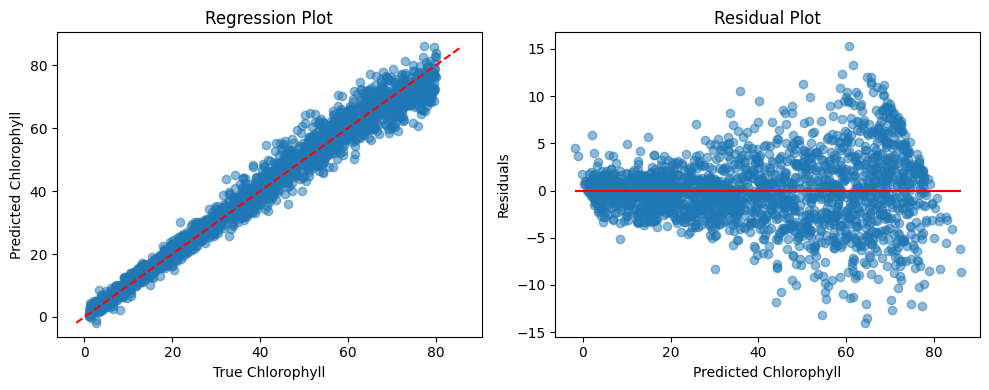

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# load the best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

preds, truths = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        out     = model(X_batch)
        preds.extend(out.cpu().numpy().flatten())
        truths.extend(y_batch.numpy().flatten())

# compute metrics
mae = mean_absolute_error(truths, preds)
r2  = r2_score(truths, preds)
print(f"Validation MAE: {mae:.4f} | R²: {r2:.4f}")

residuals = np.array(truths) - np.array(preds)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Regression plot on the left
ax1 = axes[0]
ax1.scatter(truths, preds, alpha=0.5)
lims = [min(truths + preds), max(truths + preds)]
ax1.plot(lims, lims, 'r--')
ax1.set_xlabel('True Chlorophyll')
ax1.set_ylabel('Predicted Chlorophyll')
ax1.set_title('Regression Plot')

# Residual plot on the right
ax2 = axes[1]
ax2.scatter(preds, residuals, alpha=0.5)
ax2.hlines(0, min(preds), max(preds), 'r')
ax2.set_xlabel('Predicted Chlorophyll')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')

plt.tight_layout()
plt.show()


I am attaching the test results from Xgboost here for your reference! Your tuned model should outpefrom this performance:

MAE=3.22, R2=0.96

![xgboost](https://github.com/amirhszd/MachineLearning4RemoteSensing/blob/main/hw5/xgboost.png?raw=1)

### Hyperparamter Tuning
This part is all you. You have a base model that is performing somewhat accurately for you. Grab a package and perform hyperparameter tuning on your hyperparameters. Read Below!!!

In [ ]:
from itertools import product

# define grid
lrs      = [1e-3, 1e-4]
wd_vals  = [1e-5, 1e-6]
best_cfg = None
best_loss = float('inf')

for lr, wd in product(lrs, wd_vals):
    # reinitialize model & optimizer
    model = SpectralCNN().to(device)
    opt   = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    sch   = optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

    # quick train for a few epochs
    for epoch in range(5):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            opt.zero_grad()
            l = criterion(model(Xb), yb)
            l.backward(); opt.step()
        sch.step()

    # evaluate on val set
    model.eval()
    losses = []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            losses.append(criterion(model(Xb), yb).item())
    avg_loss = np.mean(losses)

    print(f"lr={lr:.0e}, wd={wd:.0e} → Val Loss: {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_cfg  = (lr, wd)

print(f"\nBest hyperparams → lr={best_cfg[0]:.0e}, wd={best_cfg[1]:.0e}, loss={best_loss:.4f}")


lr=1e-03, wd=1e-05 → Val Loss: 124.0065
lr=1e-03, wd=1e-06 → Val Loss: 111.0026
lr=1e-04, wd=1e-05 → Val Loss: 537.4896
lr=1e-04, wd=1e-06 → Val Loss: 539.5675

Best hyperparams → lr=1e-03, wd=1e-06, loss=111.0026
